In [1]:
from xai.policy import *
from xai.buffer import Buffer
from xai.bytes import GigaBytes
from numpy import uint8
from numpy.typing import NDArray
import matplotlib.pyplot as plt

import mnist
import torch
import random
import shap
import numpy as np

In [2]:
latent_dim = 5

In [3]:
images = torch.from_numpy(mnist.train_images())
images = images.float()/255.0

labels = torch.from_numpy(mnist.train_labels())
labels_one_hot = torch.zeros((labels.shape[0],10)).float()
labels_one_hot[torch.arange(0,labels.shape[0]),labels.int()] = 1.0

images.shape, labels_one_hot.shape

(torch.Size([60000, 28, 28]), torch.Size([60000, 10]))

In [4]:
encoder = Policy.new((28,28),latent_dim, hidden_activation="ReLU")
decoder = Policy.new(encoder.output_dim,encoder.input_dim, hidden_activation="ReLU")
autoencoder = encoder + decoder
autoencoder

CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)


Sequential(
  (0): Linear(in_features=784, out_features=524, bias=True)
  (1): ReLU()
  (2): Linear(in_features=524, out_features=264, bias=True)
  (3): ReLU()
  (4): Linear(in_features=264, out_features=5, bias=True)
  (5): Linear(in_features=5, out_features=264, bias=True)
  (6): ReLU()
  (7): Linear(in_features=264, out_features=524, bias=True)
  (8): ReLU()
  (9): Linear(in_features=524, out_features=784, bias=True)
)

In [5]:
stats = autoencoder.adam().fit(
    X=images,
    Y=images,
    epochs=1500,
    batch_size=128,
    loss_criterion="MSELoss",
    verbose=True,
    info="Autoencoder test"
)
stats[5:].plot_loss()

Loss: 0.026728: 100%|██████████| 1500/1500 [00:24<00:00, 61.21it/s]


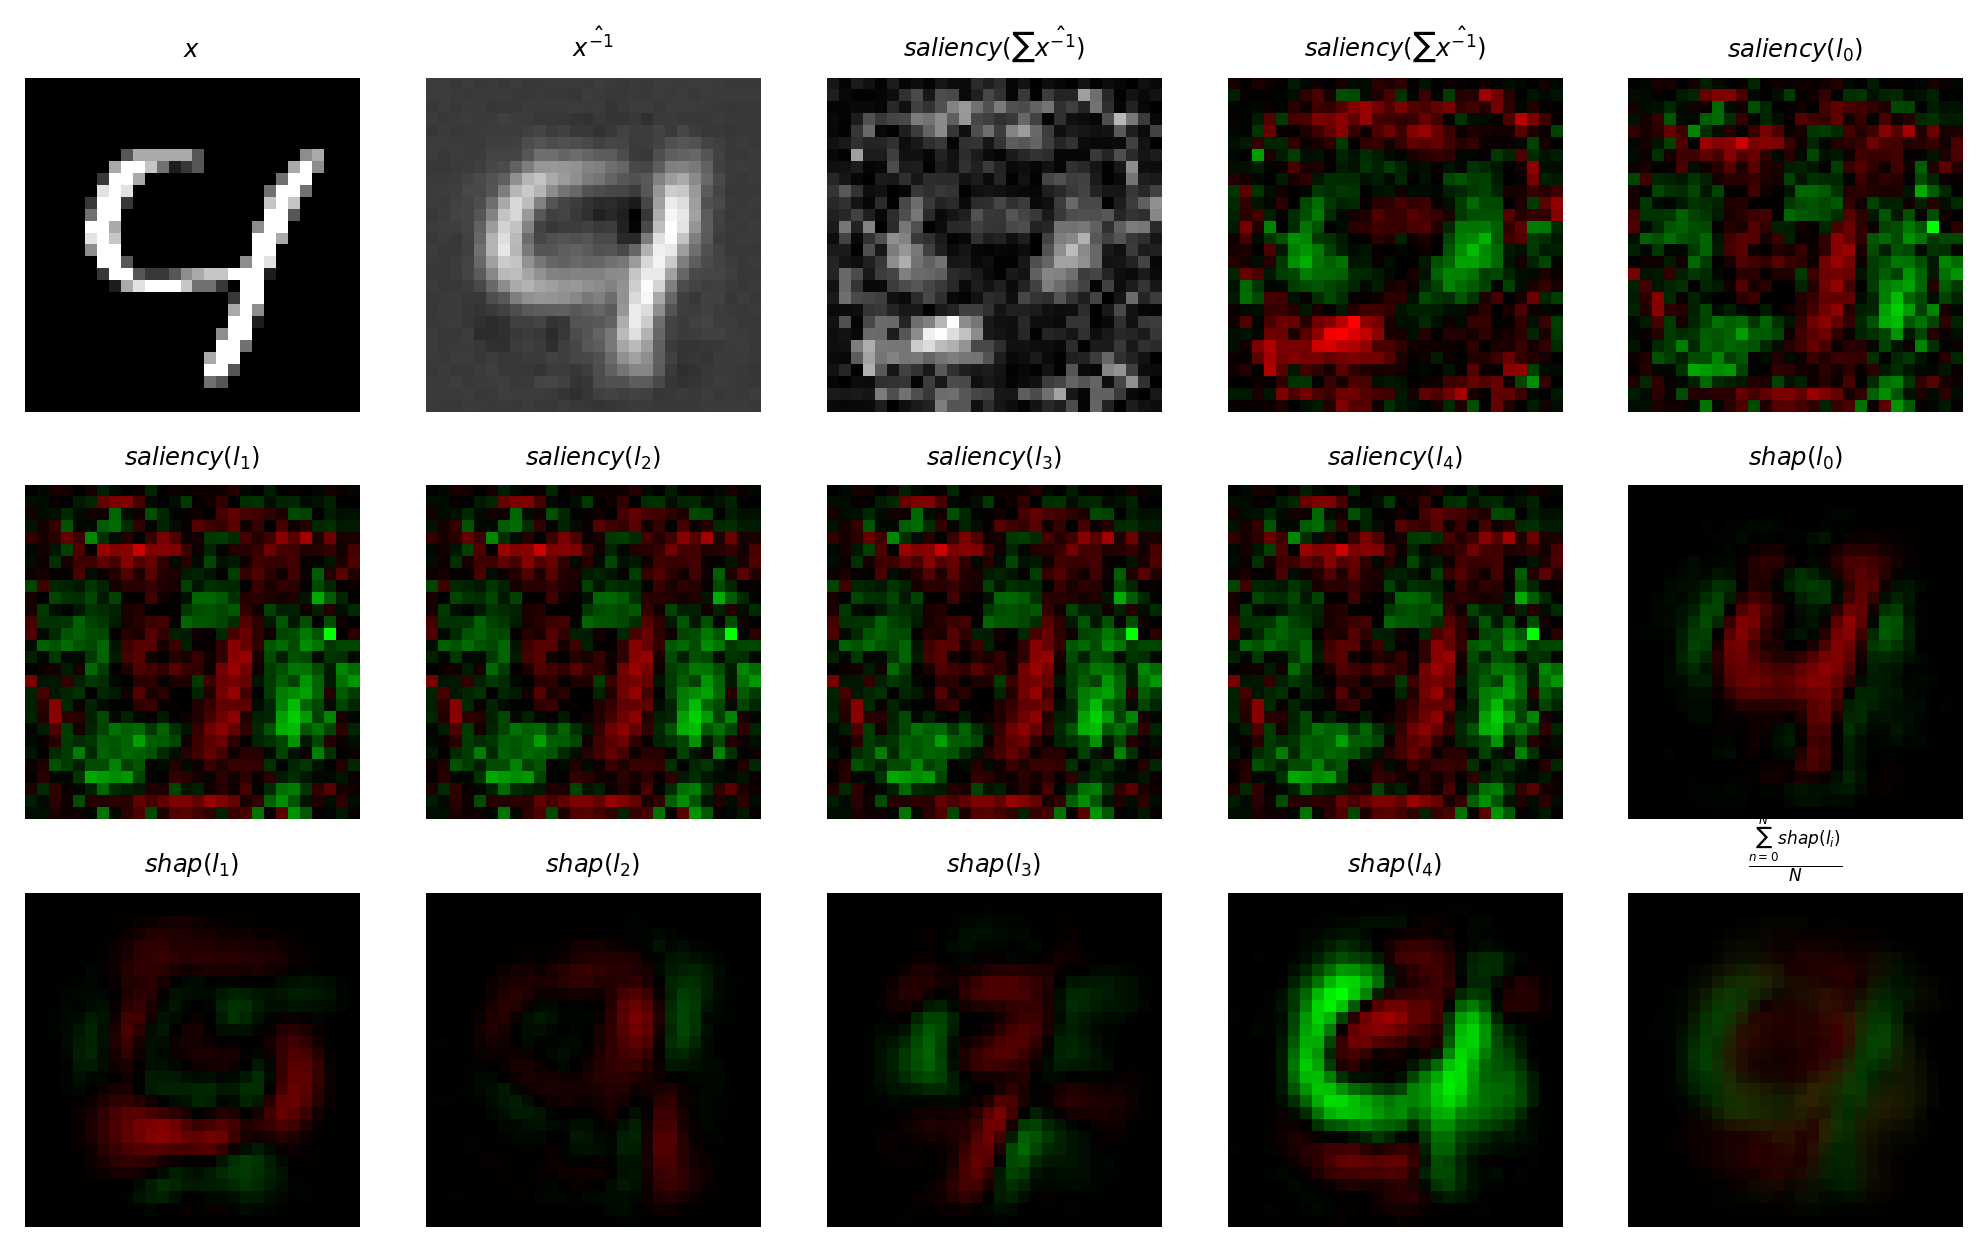

In [44]:
idx = random.randint(0,len(images))
X = images[idx]
L = encoder(X)
X_inv = autoencoder(X)
digit = X_inv.tensor(True).argmax().item()

fig = plt.figure(dpi=250, figsize=(10,6)) 
fig.add_subplot(3,5,1)
plt.imshow(X, cmap="gray") 
plt.axis('off')
plt.title(f'$x$', size=7)

fig.add_subplot(3,5, 2)
plt.imshow(X_inv.numpy(), cmap="gray") 
plt.axis('off')
plt.title(f'$\\hat{{x^{{-1}}}}$', size=7)

abs_saliency = X_inv.saliency(lambda t: t.sum())

fig.add_subplot(3,5,3)
plt.imshow(abs_saliency, cmap="gray") 
plt.axis('off')
plt.title(f"$saliency(\sum{{\\hat{{x^{{-1}}}}}})$", size=7)

gradients = X_inv.gradients(lambda t: t.sum())
min,max = gradients.min(), gradients.max()
if abs(max) > abs(min):
    min = -max
else:
    max = -min
red = torch.where(gradients < 0, gradients/min, torch.zeros_like(gradients))
green = torch.where(gradients > 0, gradients/max, torch.zeros_like(gradients))
saliency_with_corr = torch.zeros((28,28,3), dtype=torch.float32, device="cpu")
saliency_with_corr[:,:,0] = red
saliency_with_corr[:,:,1] = green

fig.add_subplot(3,5,4)
plt.imshow(saliency_with_corr, cmap="gray") 
plt.axis('off')
plt.title(f"$saliency(\sum{{\\hat{{x^{{-1}}}}}})$", size=7)

shap_images = []
for i in range(5):
    gradients = L.gradients(lambda t: t[0])
    min,max = gradients.min(), gradients.max()
    if abs(max) > abs(min):
        min = -max
    else:
        max = -min
    red = torch.where(gradients < 0, gradients/min, torch.zeros_like(gradients))
    green = torch.where(gradients > 0, gradients/max, torch.zeros_like(gradients))
    latent_saliency = torch.zeros((28,28,3), dtype=torch.float32, device="cpu")
    latent_saliency[:,:,0] = red
    latent_saliency[:,:,1] = green
    fig.add_subplot(3,5,i+5)
    plt.imshow(latent_saliency, cmap="gray")
    plt.axis('off')
    plt.title(f'$saliency(l_{i})$', size=7)

data = encoder(images).numpy()
explainer = shap.PermutationExplainer(lambda t: decoder(torch.from_numpy(t)).numpy().reshape((-1,784)), masker=data)
autoencoder_shap_values: shap.Explanation = explainer(data[idx:idx+1], max_evals=11)[0]
autoencoder_shap_values = np.array(autoencoder_shap_values.values).reshape((latent_dim,28,28))

min,max = autoencoder_shap_values.min(), autoencoder_shap_values.max()
if abs(max) > abs(min):
    min = -max
else:
    max = -min
red = np.where(autoencoder_shap_values < 0, autoencoder_shap_values/min, np.zeros_like(autoencoder_shap_values))
green = np.where(autoencoder_shap_values > 0, autoencoder_shap_values/max, np.zeros_like(autoencoder_shap_values))

shap_images = []
for i in range(5):
    image = np.zeros((28,28,3), dtype=np.float32)
    image[:,:,0] = red[i]
    image[:,:,1] = green[i]
    shap_images.append(image)
    fig.add_subplot(3,5,i+10)
    plt.imshow(shap_images[-1], cmap="gray")
    plt.axis('off')
    plt.title(f'$shap(l_{i})$', size=7)

fig.add_subplot(3,5,15)
plt.imshow(np.stack(shap_images).mean(axis=0))
plt.axis('off')
plt.title(f'$\\frac{{\sum_{{n=0}}^{{N}}{{shap(l_{{i}})}}}}{{N}}$', size=7)
plt.show()

In [8]:
classifier_head = Policy.new(encoder.output_dim,10, hidden_activation="ReLU")
classifier = encoder + classifier_head
classifier

Sequential(
  (0): Linear(in_features=784, out_features=524, bias=True)
  (1): ReLU()
  (2): Linear(in_features=524, out_features=264, bias=True)
  (3): ReLU()
  (4): Linear(in_features=264, out_features=5, bias=True)
  (5): Linear(in_features=5, out_features=6, bias=True)
  (6): ReLU()
  (7): Linear(in_features=6, out_features=8, bias=True)
  (8): ReLU()
  (9): Linear(in_features=8, out_features=10, bias=True)
)

In [11]:
stats = classifier_head.adam().fit(
    X=encoder(images),
    Y=labels_one_hot,
    epochs=5000,
    batch_size=64,
    loss_criterion="CrossEntropyLoss",
    verbose=True,
    info="Classifier test"
)
stats.plot_loss()

Loss: 0.488327: 100%|██████████| 5000/5000 [00:17<00:00, 278.18it/s]


/tmp/ipykernel_5644/1736889429.py:52: RuntimeWarning:

invalid value encountered in divide



(5, 10)

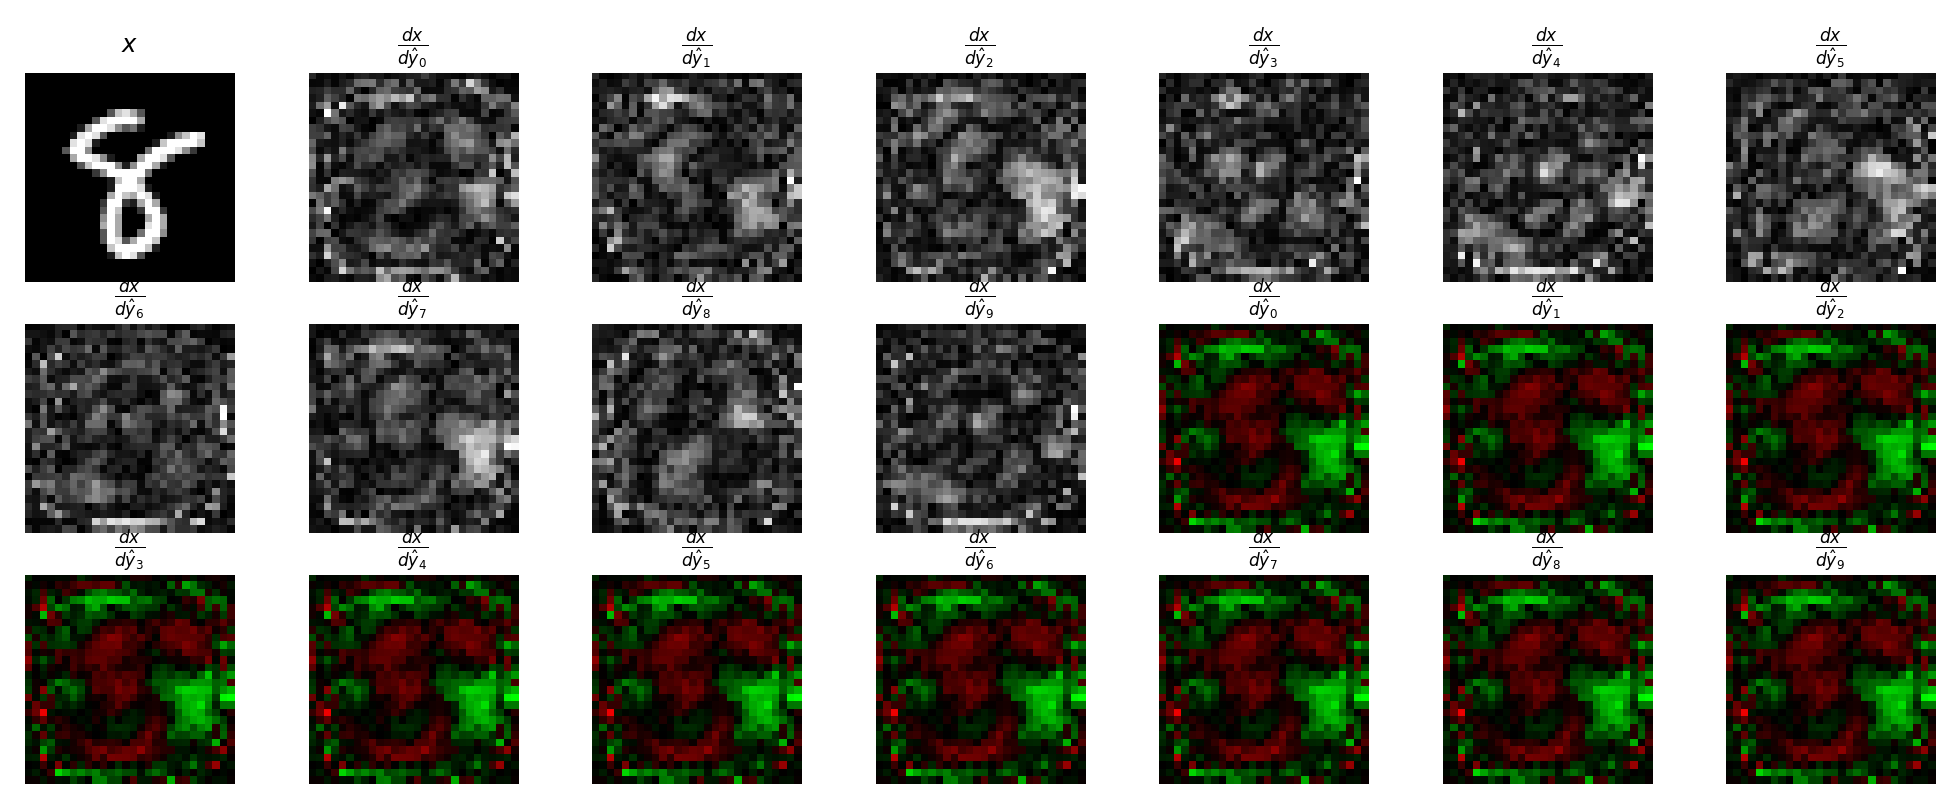

In [29]:
idx = random.randint(0,len(images))
X = images[idx]
Y = classifier(X)
digit = Y.tensor(True).argmax().item()

fig = plt.figure(dpi=250, figsize=(10,5)) 
fig.add_subplot(4,7, 1)
plt.imshow(X, cmap="gray") 
plt.axis('off')
plt.title(f'$x$', size=7)

saliencies = []
for i in range(10):
    fig.add_subplot(4,7,i+2)
    saliencies.append(Y.saliency(lambda t: t[i]))
    plt.imshow(saliencies[-1], cmap="gray")
    plt.axis('off')
    plt.title(f'$\\frac{{dx}}{{d\hat y_{i}}}$', size=7)


for i in range(10):
    gradients = Y.gradients(lambda t: t.sum())
    min,max = gradients.min(), gradients.max()
    if abs(max) > abs(min):
        min = -max
    else:
        max = -min
    red = torch.where(gradients < 0, gradients/min, torch.zeros_like(gradients))
    green = torch.where(gradients > 0, gradients/max, torch.zeros_like(gradients))
    saliency_with_corr = torch.zeros((28,28,3), dtype=torch.float32, device="cpu")
    saliency_with_corr[:,:,0] = red
    saliency_with_corr[:,:,1] = green
    fig.add_subplot(4,7,i+12)
    plt.imshow(saliency_with_corr, cmap="gray")
    plt.axis('off')
    plt.title(f'$\\frac{{dx}}{{d\hat y_{i}}}$', size=7)


data = encoder(images).numpy()
explainer = shap.PermutationExplainer(lambda t: classifier_head(torch.from_numpy(t)).numpy().reshape((-1,10)), masker=data)
classifier_head_shap_values: shap.Explanation = explainer(data[idx:idx+1], max_evals=11)[0]
classifier_head_shap_values = np.array(classifier_head_shap_values.values).reshape((latent_dim,10))

classifier_head_shap_min, classifier_head_shap_max = classifier_head_shap_values.min(), classifier_head_shap_values.max()
if abs(classifier_head_shap_max) > abs(classifier_head_shap_min):
    classifier_head_shap_min = -classifier_head_shap_max
else:
    classifier_head_shap_max = -classifier_head_shap_min


negative = np.where(classifier_head_shap_values < 0, classifier_head_shap_values / classifier_head_shap_min, np.zeros_like(classifier_head_shap_values))
negative = negative / negative.sum(axis=0)

positive = np.where(classifier_head_shap_values > 0, classifier_head_shap_values / classifier_head_shap_max, np.zeros_like(classifier_head_shap_values))
positive = positive / positive.sum(axis=0)

positive.shape

Disk used: 0.50/0.50GB: : 1592it [00:02, 574.61it/s]


(Buffer(use_ram=False, entries=1592, size=499.90MB, capacity=99.98%),
 torch.Size([280, 280]))

Sequential(
  (0): Linear(in_features=78400, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=5, bias=True)
  (7): Linear(in_features=5, out_features=32, bias=True)
  (8): ReLU()
  (9): Linear(in_features=32, out_features=64, bias=True)
  (10): ReLU()
  (11): Linear(in_features=64, out_features=256, bias=True)
  (12): ReLU()
  (13): Linear(in_features=256, out_features=78400, bias=True)
)

Loss: 0.053960:   6%|▌         | 59/1000 [00:20<05:30,  2.85it/s]


KeyboardInterrupt: 

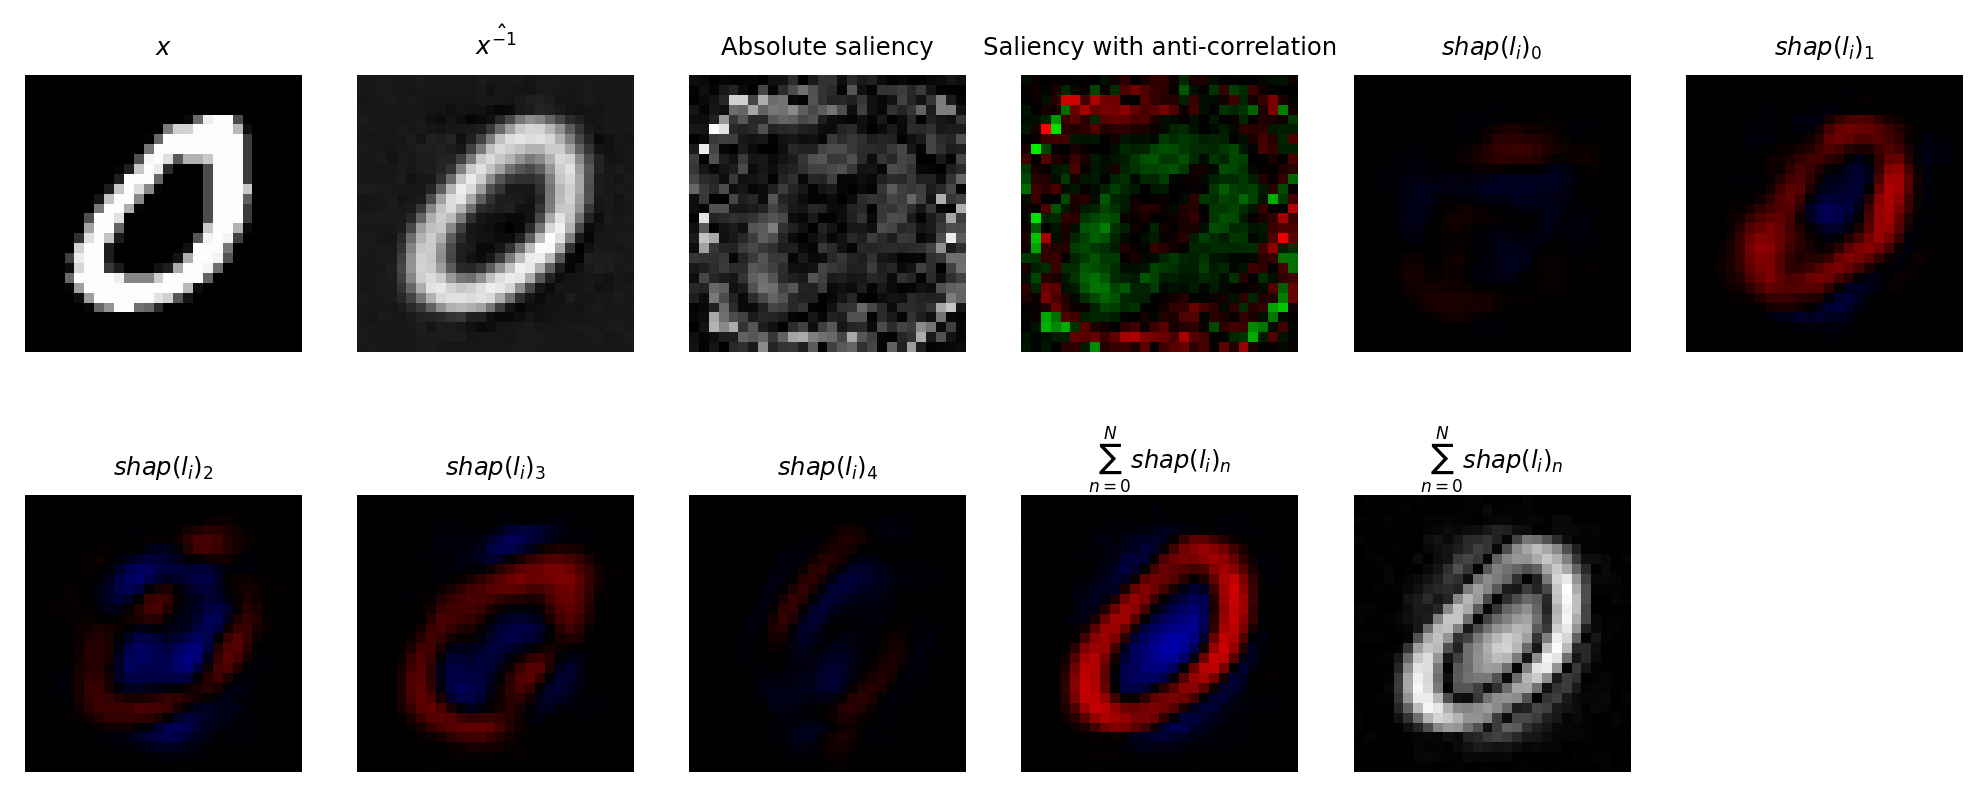

In [28]:
idx = random.randint(0,len(images))
X = images[idx]
X_inv = autoencoder(X)
digit = X_inv.tensor().argmax().item()

fig = plt.figure(dpi=250, figsize=(10,4)) 
fig.add_subplot(2,6,1)
plt.imshow(X, cmap="gray") 
plt.axis('off')
plt.title(f'$x$', size=7)

fig.add_subplot(2,6, 2)
plt.imshow(X_inv.numpy(), cmap="gray") 
plt.axis('off')
plt.title(f'$\\hat{{x^{{-1}}}}$', size=7)

abs_saliency = X_inv.saliency(lambda t: t.sum())

fig.add_subplot(2,6,3)
plt.imshow(abs_saliency, cmap="gray") 
plt.axis('off')
plt.title(f"Absolute saliency", size=7)

gradients = X_inv.gradients(lambda t: t.sum())
min,max = gradients.min(), gradients.max()
if abs(max) > abs(min):
    min = -max
else:
    max = -min
red = torch.where(gradients < 0, gradients/min, torch.zeros_like(gradients))
green = torch.where(gradients > 0, gradients/max, torch.zeros_like(gradients))
saliency_with_corr = torch.zeros((28,28,3), dtype=torch.float32, device="cpu")
saliency_with_corr[:,:,0] = red
saliency_with_corr[:,:,1] = green

fig.add_subplot(2,6,4)
plt.imshow(saliency_with_corr, cmap="gray") 
plt.axis('off')
plt.title(f"Saliency with anti-correlation", size=7)

data = encoder(images).numpy()
explainer = shap.PermutationExplainer(lambda t: decoder(torch.from_numpy(t)).numpy().reshape((-1,784)), masker=data)
autoencoder_shap_values: shap.Explanation = explainer(data[idx:idx+1], max_evals=11)[0]
autoencoder_shap_values = np.array(autoencoder_shap_values.values).reshape((latent_dim,28,28))

shap_sum = autoencoder_shap_values.sum(0)
min,max = shap_sum.min(), shap_sum.max()
if abs(max) > abs(min):
    min = -max
else:
    max = -min
blue = np.where(autoencoder_shap_values < 0, autoencoder_shap_values/min, np.zeros_like(autoencoder_shap_values))
red = np.where(autoencoder_shap_values > 0, autoencoder_shap_values/max, np.zeros_like(autoencoder_shap_values))

shap_images = []
for i in range(5):
    image = np.zeros((28,28,3), dtype=np.float32)
    image[:,:,0] = red[i]
    image[:,:,2] = blue[i]
    shap_images.append(image)
    fig.add_subplot(2,6,i+5)
    plt.imshow(shap_images[-1], cmap="gray")
    plt.axis('off')
    plt.title(f'$shap(l_{{i}})_{i}$', size=7)


image = np.zeros((28,28,3), dtype=np.float32)
image[:,:,2] = np.where(shap_sum < 0, -shap_sum, np.zeros_like(shap_sum))
image[:,:,0] = np.where(shap_sum > 0, shap_sum, np.zeros_like(shap_sum))

fig.add_subplot(2,6,10)
plt.imshow(image)
plt.axis('off')
plt.title(f'$\sum_{{n=0}}^{{N}}{{shap(l_{{i}})_{{n}}}}$', size=7)

fig.add_subplot(2,6,11)
plt.imshow(image.mean(axis=2), cmap="gray")
plt.axis('off')
plt.title(f'$\sum_{{n=0}}^{{N}}{{shap(l_{{i}})_{{n}}}}$', size=7)
plt.show()